In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import datetime
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
tf.random.set_seed(1)
np.random.seed(1)
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("/content/drive/MyDrive/colab/account_data.csv",parse_dates = True)

In [26]:
a = list(df['accountId'].unique())
df = df[df['accountId']=="5ffdb895b08512986422b08c"]
df=df.copy()
df.date = pd.to_datetime(df.date)
df.sort_values(by="date", inplace=True, ignore_index=True)
account_data = df

In [27]:
keyword_ids = account_data["keywordId"].unique()
keywordwise_sales = account_data.groupby("keywordId")["sales"].sum()
nonzero_sales_keywords = keywordwise_sales[keywordwise_sales>0]
nonzero_sales_keywords.sort_values(ascending=False, inplace=True)
keywords_req = list(nonzero_sales_keywords.index)
keyword_ids = keywords_req[:35]
account_data =  account_data[account_data['keywordId'].isin(keyword_ids)]

In [28]:
account_data.reset_index(inplace = True)
account_data.sort_values(by="date", inplace=True, ignore_index=True)
account_data.drop(columns = "index",inplace = True)
account_data.sort_values(by = 'date',inplace = True)
account_data.reset_index(inplace = True)
account_data.drop(columns = "index",inplace = True)
account_data['clicks'] = account_data["clicks"].astype("int64")
account_data['impressions'] = account_data["impressions"].astype("int64")
account_data['orders'] = account_data["orders"].astype("int64")
account_data["keywordId"] = account_data["keywordId"].astype(str)
account_data["cpc"] = account_data["spend"]/account_data["clicks"] 
account_data["cpc"].interpolate("linear", inplace=True)

In [29]:
account_data.set_index('date',inplace = True)

In [30]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [31]:
account_data = account_data[account_data['sales']>1000] 
account_data = account_data[account_data['sales']<45000]

In [32]:
account_data

,accountId,adGroupId,campaignId,keywordId,sales,spend,clicks,impressions,orders,cpc
date,,,,,,,,,,
2022-01-20,5ffdb895b08512986422b08c,205031194777134,63953084720638,187760894834115,8822.540000,298.930000,120,3727,13,2.491083
2022-01-20,5ffdb895b08512986422b08c,29667499780453,85722658525534,85472206701258,2625.420000,1910.220000,96,26074,3,19.898125
2022-01-20,5ffdb895b08512986422b08c,155972832827060,85580432953015,2765709881042,32964.460000,3167.270000,361,5702,26,8.773601
2022-01-20,5ffdb895b08512986422b08c,155972832827060,85580432953015,67652894855323,9680.500000,1250.170000,91,2466,7,13.738132
2022-01-20,5ffdb895b08512986422b08c,218427629916993,85580432953015,87296464240522,1270.340000,160.160000,21,200,1,7.626667
...,...,...,...,...,...,...,...,...,...,...
2023-01-20,5ffdb895b08512986422b08c,196156035254768,42405100299601,210247423029007,6316.081499,197.860847,95,7991,7,2.082746
2023-01-20,5ffdb895b08512986422b08c,171114893832742,30363257828591,90306352578146,8021.079611,335.237871,109,7971,3,3.075577
2023-01-20,5ffdb895b08512986422b08c,201638832359263,2290415637360,185293015123540,14523.892098,232.526232,39,7947,5,5.962211


In [33]:
validate = account_data[['sales','spend', 'clicks', 'impressions', 'orders','keywordId']].tail(1000)
account_data.drop(account_data.tail(1000).index,inplace=True)

In [34]:
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = x_scaler.fit_transform(account_data[['sales','spend', 'clicks', 'impressions', 'orders']])
dataY = y_scaler.fit_transform(account_data[['sales']])

In [35]:
hist_window = 1000
horizon = 1000
TRAIN_SPLIT = 6000
x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
x_val_multi, y_val_multi= custom_ts_multi_data_prep(
    dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)

In [36]:
print ('Single window of past history')
print(x_train_multi[0])
print(len(x_train_multi[0]))
print('\n Target horizon')
print(y_train_multi[0])
print(len(y_train_multi[0]))

Single window of past history
[[0.17853533 0.02256689 0.2690583  0.00876293 0.31707317]
 [0.03707575 0.14685007 0.21524664 0.06248723 0.07317073]
 [0.72961484 0.24380975 0.80941704 0.01351101 0.63414634]
 ...
 [0.03629363 0.00820664 0.13004484 0.01599204 0.04878049]
 [0.09330983 0.05796737 0.16591928 0.03073875 0.04878049]
 [0.32190645 0.12355914 0.52242152 0.02805578 0.82926829]]
1000

 Target horizon
[[0.08265309]
 [0.12309837]
 [0.17859107]
 [0.07776743]
 [0.15772181]
 [0.03006979]
 [0.00872702]
 [0.67435996]
 [0.0406256 ]
 [0.11908298]
 [0.05300825]
 [0.00351976]
 [0.30879865]
 [0.36739728]
 [0.14432533]
 [0.05878338]
 [0.08665084]
 [0.40483709]
 [0.06432649]
 [0.26004202]
 [0.28582407]
 [0.06855953]
 [0.12295086]
 [0.17701909]
 [0.05168581]
 [0.09089198]
 [0.12113484]
 [0.00546183]
 [0.14884352]
 [0.38678939]
 [0.11665124]
 [0.62281635]
 [0.05212315]
 [0.00435352]
 [0.01084538]
 [0.05898709]
 [0.04015153]
 [0.06264394]
 [0.11432686]
 [0.29634441]
 [0.02690559]
 [0.07202686]
 [0.36

In [37]:
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [38]:
ED_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=x_train_multi.shape[-2:], return_sequences=True),
    tf.keras.layers.LSTM(units=32,return_sequences=True),
    tf.keras.layers.LSTM(units=16,return_sequences=True),
    tf.keras.layers.LSTM(units=15),
    tf.keras.layers.RepeatVector(y_train_multi.shape[1]), 
    tf.keras.layers.LSTM(units=64,return_sequences=True),
    tf.keras.layers.LSTM(units=32,return_sequences=True),
    tf.keras.layers.LSTM(units=16,return_sequences=True),
    tf.keras.layers.Dense(units=1)
])
ED_lstm_model.compile(optimizer='adam', loss='mse')

In [39]:
model_path = 'Encoder_Decoder_LSTM_Multivariate_sales_only_more.h5'

In [ ]:
model_path = 'Encoder_Decoder_LSTM_Multivariate_sales_only_more.h5'
EVALUATION_INTERVAL = 100
EPOCHS = 100
history = ED_lstm_model.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data_multi, validation_steps=50,verbose =1,
                              callbacks =[
                                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
                                  tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)
                              ]
                           )

Epoch 1/100
100/100 [==============================] - 44s 287ms/step - loss: 0.0288 - val_loss: 0.0281
Epoch 2/100
100/100 [==============================] - 26s 262ms/step - loss: 0.0278 - val_loss: 0.0275
Epoch 3/100
100/100 [==============================] - 28s 278ms/step - loss: 0.0277 - val_loss: 0.0274
Epoch 4/100
100/100 [==============================] - 26s 261ms/step - loss: 0.0276 - val_loss: 0.0273
Epoch 5/100
100/100 [==============================] - 26s 262ms/step - loss: 0.0276 - val_loss: 0.0272
Epoch 6/100
100/100 [==============================] - 27s 269ms/step - loss: 0.0275 - val_loss: 0.0272
Epoch 7/100
100/100 [==============================] - 26s 261ms/step - loss: 0.0275 - val_loss: 0.0270
Epoch 8/100
100/100 [==============================] - 26s 261ms/step - loss: 0.0275 - val_loss: 0.0269
Epoch 9/100
100/100 [==============================] - 26s 261ms/step - loss: 0.0274 - val_loss: 0.0268
Epoch 10/100
100/100 [==============================] - 26s 260m

In [40]:
Trained_model = tf.keras.models.load_model("/content/Encoder_Decoder_LSTM_Multivariate_sales_only_more.h5")

In [41]:
Trained_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 1000, 64)          17920     
                                                                 
 lstm_15 (LSTM)              (None, 1000, 32)          12416     
                                                                 
 lstm_16 (LSTM)              (None, 1000, 16)          3136      
                                                                 
 lstm_17 (LSTM)              (None, 15)                1920      
                                                                 
 repeat_vector_2 (RepeatVect  (None, 1000, 15)         0         
 or)                                                             
                                                                 
 lstm_18 (LSTM)              (None, 1000, 64)          20480     
                                                      

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [20,6]
plt.show()

NameError: ignored

In [43]:
data_val = x_scaler.fit_transform(account_data[['sales','spend','orders','clicks','impressions']].tail(1000))
print(data_val)
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print(data_val.shape)
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
print(val_rescaled)
print(val_rescaled.shape)
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
Predicted_results = Trained_model.predict(val_rescaled)[0]
print(Predicted_results)
print(len(Predicted_results))
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results.reshape(-1,1))
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print(Predicted_results_Inv_trans)
print(len(Predicted_results_Inv_trans))

[[0.08411528 0.00832549 0.03703704 0.01176471 0.02620369]
 [0.03960385 0.03025631 0.03703704 0.04235294 0.01627132]
 [0.12133117 0.10283394 0.03703704 0.07294118 0.27810639]
 ...
 [0.76594181 1.         0.44444444 0.68705882 0.33654991]
 [0.07562762 0.11066652 0.07407407 0.09176471 0.21463612]
 [0.11021285 0.13439498 0.11111111 0.11294118 0.16089634]]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
(1000, 5)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
[[[0.08411528 0.00832549 0.03703704 0.01176471 0.02620369]
  [0.03960385 0.03025631 0.03703704 0.04235294 0.01627132]
  [0.12133117 0.10283394 0.03703704 0.07294118 0.27810639]
  ...
  [0.76594181 1.         0.44444444 0.68705882 0.33654991]
  [0.07562762 0.11066652 0.07407407 0.09176471 0.21463612]
  [0.11021285 0.13439498 0.11111111 0.11294118 0.16089634]]]
(1, 1000, 5)
%%%

In [44]:
testing = validate.copy()
testing[['pred_sales']] = Predicted_results_Inv_trans

In [45]:
testing['keywordId'].unique()

array(['187760894834115', '148684437353570', '87296464240522',
       '13560133409311', '79454459707340', '85472206701258',
       '67652894855323', '86403799082238', '189229237302837',
       '234485565812381', '227590663052584', '67530812369819',
       '228625472493978', '234598292844815', '210247423029007',
       '14934981931705', '64265992690180', '90306352578146',
       '247863105542037', '178337812269813', '202640426426128',
       '115183597326876', '197034671889267', '272872700879778',
       '190918643002238', '185293015123540', '116716807274101'],
      dtype=object)

In [46]:
testing[testing['keywordId'] == '85472206701258']

,sales,spend,clicks,impressions,orders,keywordId,pred_sales
date,,,,,,,
2022-12-13,9770.713900,1567.159497,96,31248,3,85472206701258,8608.970703
2022-12-14,11109.085380,1595.504897,97,31316,3,85472206701258,9050.102539
2022-12-15,9627.873996,1619.893577,97,31542,3,85472206701258,9051.375977
2022-12-16,9430.373463,1619.519767,96,31418,3,85472206701258,9051.382812
2022-12-17,10052.875668,1571.065132,93,31059,3,85472206701258,9051.382812
2022-12-18,9389.893579,1591.352447,94,30503,3,85472206701258,9051.382812
2022-12-19,9492.710435,1594.630788,95,30245,3,85472206701258,9051.382812
2022-12-20,8227.015711,1568.606683,95,30105,2,85472206701258,9051.382812
2022-12-21,7982.509616,1561.623125,95,30565,2,85472206701258,9051.382812


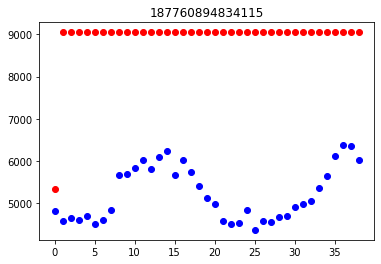

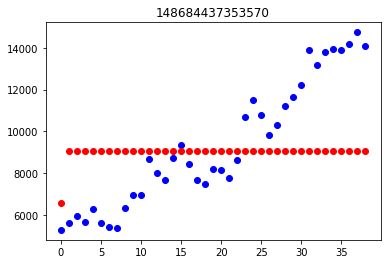

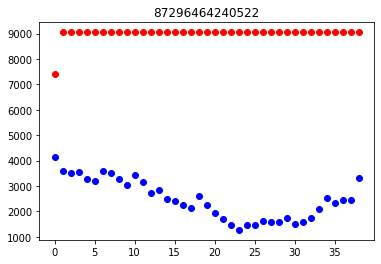

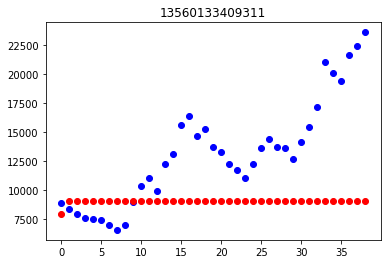

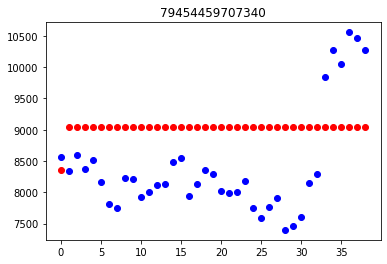

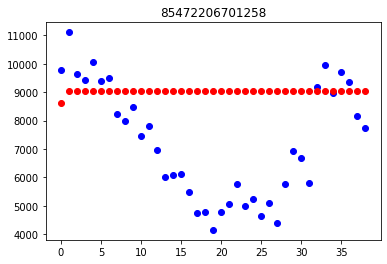

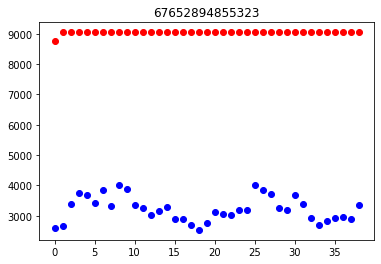

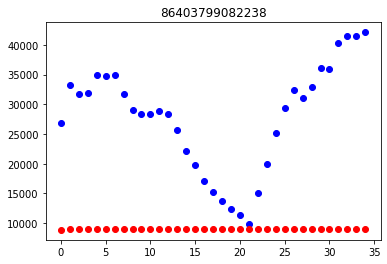

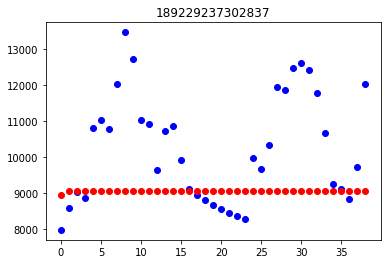

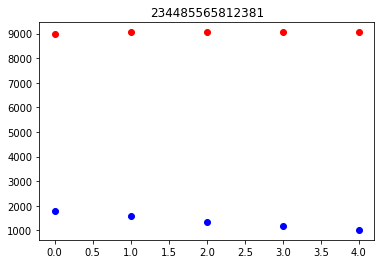

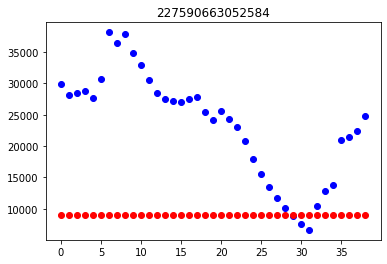

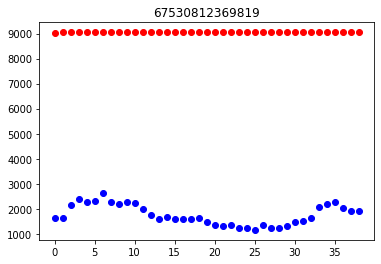

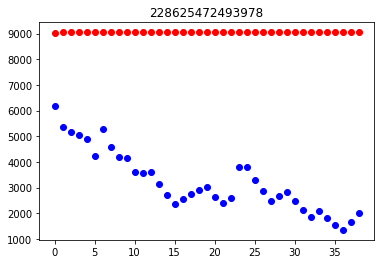

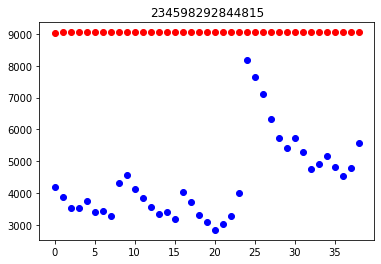

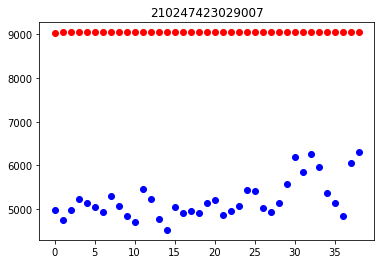

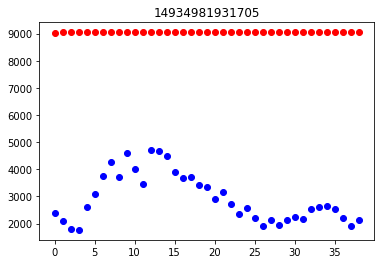

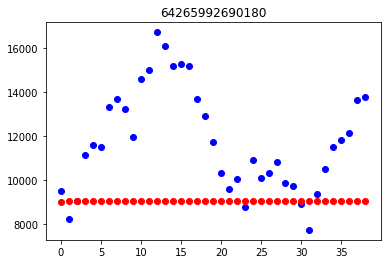

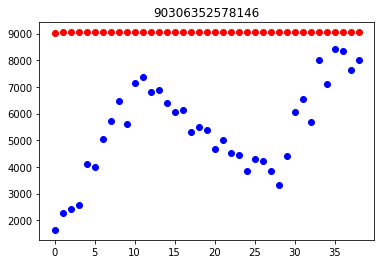

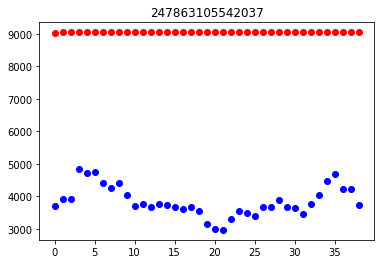

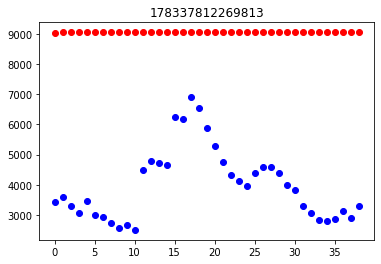

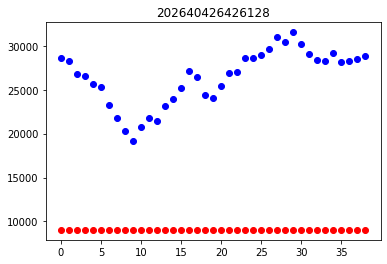

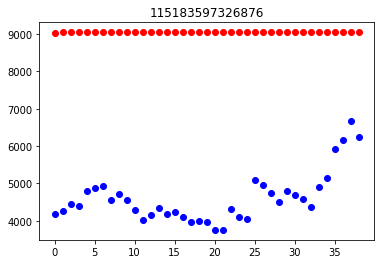

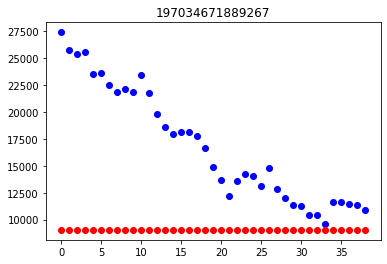

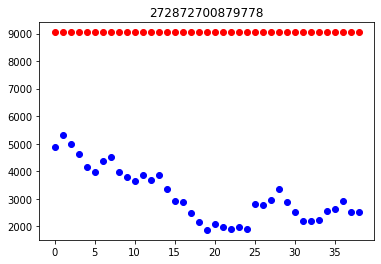

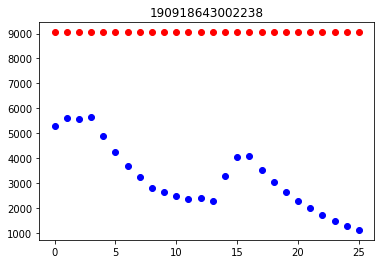

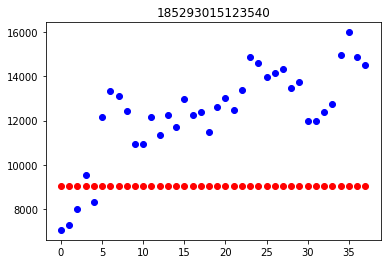

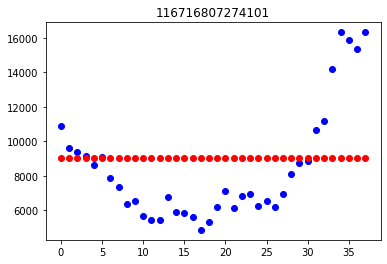

In [58]:
import matplotlib.pyplot as plt
import numpy as np
for i in range(len(testing['keywordId'].unique())):
    def plotGraph(y_test,y_pred,s):
        if max(y_test) >= max(y_pred):
            my_range = int(max(y_test))
        else:
            my_range = int(max(y_pred))
        plt.scatter(range(len(y_test)), y_test, color='blue')
        plt.scatter(range(len(y_pred)), y_pred, color='red')
        plt.title(s)
        plt.show()
        return
    s = testing['keywordId'].unique()[i]    
    y_sales = testing[testing['keywordId'] == s]['sales']
    y_pred_sales = testing[testing['keywordId'] == s]['pred_sales']
    plotGraph(y_sales, y_pred_sales,s)

In [52]:
testing['keywordId'].unique()[9]

'234485565812381'